In [ ]:
!pip install transformers
!pip install datasets
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('final_speeches_dataset.csv', encoding='utf-8', delimiter=',', on_bad_lines='skip', engine='python')
print(df.head())

    MPID        Party        Date  \
0  16659  ['kpd/dkp']  1949-09-07   
1  15677      ['spd']  1949-09-07   
2  16631      ['spd']  1949-09-07   
3  16631      ['spd']  1949-09-07   
4  16631      ['spd']  1949-09-07   

                                              Speech Political Orientation  
0                                      Sehr richtig!             communist  
1                               Alterspräsident Löbe    social democtratic  
2   nicht in der Form und im Sinne von Almosen, s...    social democtratic  
3   nicht in der Form und im Sinne von Almosen, s...    social democtratic  
4   nicht in der Form und im Sinne von Almosen, s...    social democtratic  


In [ ]:
#Data Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2429 entries, 0 to 2428
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   MPID                   2429 non-null   int64 
 1   Party                  2429 non-null   object
 2   Date                   2429 non-null   object
 3   Speech                 2429 non-null   object
 4   Political Orientation  2429 non-null   object
dtypes: int64(1), object(4)
memory usage: 95.0+ KB


In [ ]:
print(df.isnull().sum())

MPID                     0
Party                    0
Date                     0
Speech                   0
Political Orientation    0
dtype: int64


In [ ]:
#Encoding Labels

In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Political Orientation'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'communist': 0, 'conservative': 1, 'liberal': 2, 'other': 3, 'right wing populist': 4, 'social democtratic': 5}


In [ ]:
#Split Dataset

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Speech'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-german-cased", num_labels=len(label_mapping))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Creating a Pytorch Dataset

In [ ]:
class SpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length
        )
        self.labels = labels

    def __getitem__(self, idx):
        # Convert each item to PyTorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Create datasets
train_dataset = SpeechDataset(train_texts, train_labels, tokenizer)
test_dataset = SpeechDataset(test_texts, test_labels, tokenizer)

In [ ]:
#Finetuning Process

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback

In [ ]:
# Adjusted Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=16,  # Batch size per device during training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # Increased weight decay to improve regularization
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=500,               # Logging frequency
    evaluation_strategy="steps",   # Evaluate at regular intervals
    save_steps=1000,                 # Save model every 1000 steps
    eval_steps=500,                  # Evaluate every 500 steps
    max_steps=7000,                  # Stop training after 7000 steps
    report_to="none",               # Turn off reporting to external trackers
    save_total_limit=3,              # Limit the number of saved checkpoints to save disk space
    load_best_model_at_end=True,     # Automatically load the best model at the end of training
    learning_rate=5e-5,              # Default learning rate; adjust if necessary
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,                         # The instantiated Transformers model to be trained
    args=training_args,                  # Training arguments, defined above
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset,           # Evaluation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping after 2 rounds of no improvement
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
500,0.138300,0.187070
1000,0.137300,0.210125
1500,0.094200,0.186703
2000,0.093800,0.202650
2500,0.119700,0.254878
3000,0.101700,0.228179


TrainOutput(global_step=3000, training_loss=0.11416502507527669, metrics={'train_runtime': 960.5268, 'train_samples_per_second': 116.603, 'train_steps_per_second': 7.288, 'total_flos': 1.2572950202892288e+16, 'train_loss': 0.11416502507527669, 'epoch': 24.59016393442623})

In [ ]:
raw_pred, _, _ = trainer.predict(test_dataset)

In [ ]:
y_pred = np.argmax(raw_pred, axis=1)
y_true = test_labels

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Get the inverse of label mapping
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
# Identify unique classes in y_true
unique_classes = np.unique(y_true)

# Create target names dynamically for only the classes present in y_true
target_names = [inverse_label_mapping[i] for i in unique_classes]

# Generate the classification report
print(classification_report(y_true, y_pred, target_names=target_names))


                     precision    recall  f1-score   support

          communist       1.00      0.33      0.50         6
       conservative       0.90      0.87      0.88       142
            liberal       0.78      0.95      0.85        93
right wing populist       1.00      0.42      0.59        19
 social democtratic       0.94      0.94      0.94       226

           accuracy                           0.89       486
          macro avg       0.92      0.70      0.75       486
       weighted avg       0.90      0.89      0.89       486



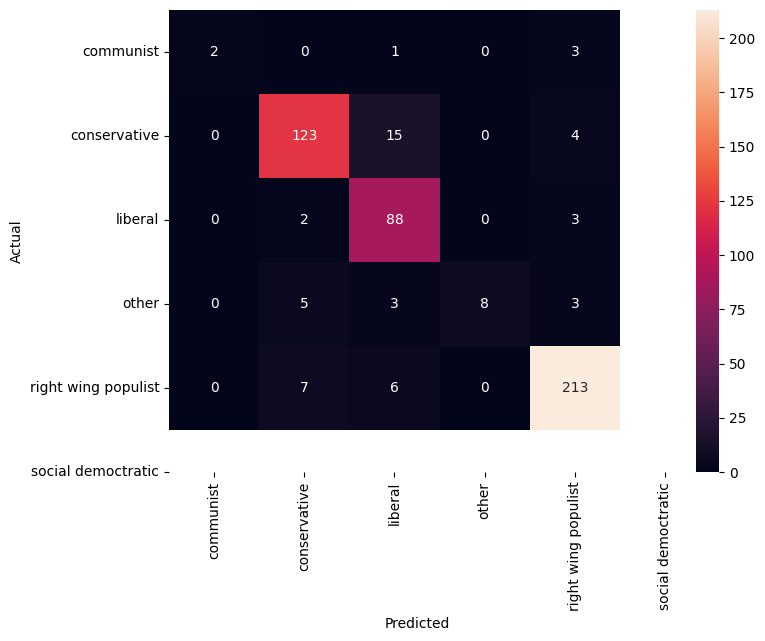

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=[inverse_label_mapping[i] for i in range(len(label_mapping))],
            yticklabels=[inverse_label_mapping[i] for i in range(len(label_mapping))])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#UI

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
model = trainer.model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch

In [ ]:
# Inverse mapping from label ids to label names
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

In [ ]:
import gradio as gr

In [ ]:
def predict_political_orientation(speech_text):
    """
    Predict the political orientation of the given speech text.
    """
    try:
        model.eval()  # Set the model to evaluation mode

        # Tokenize and move inputs to the appropriate device
        inputs = tokenizer(
            speech_text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

            # Move logits to CPU before converting to NumPy
            probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
            predicted_class = torch.argmax(logits, dim=1).item()

        # Convert predicted class ID to the label name
        prediction_label = inverse_label_mapping.get(predicted_class, "Unknown")
        return f"Predicted Political Orientation: {prediction_label}"

    except Exception as e:
        # Return the error message for easier debugging
        return f"An error occurred during prediction: {str(e)}"

In [ ]:
interface = gr.Interface(
    fn=predict_political_orientation,  # Your prediction function
    inputs=gr.Textbox(lines=10, placeholder='Enter the speech here...'),
    outputs=gr.Textbox(label="Prediction"),
    title='Political Orientation Predictor',
    description='Enter a speech and predict its political orientation.',
    examples=[
        ['This government is working tirelessly for the people.'],
        ['The workers need to rise against the oppressive capitalists.'],
        ['We stand by the conservative values of family and nation.'],
    ]
)

In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://70376b30a2340fee1c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
model_save_path = "./political_orientation_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./political_orientation_model/tokenizer_config.json',
 './political_orientation_model/special_tokens_map.json',
 './political_orientation_model/vocab.txt',
 './political_orientation_model/added_tokens.json',
 './political_orientation_model/tokenizer.json')

In [ ]:
from google.colab import files
!zip -r model.zip ./political_orientation_model
files.download("model.zip")

  adding: political_orientation_model/ (stored 0%)
  adding: political_orientation_model/config.json (deflated 54%)
  adding: political_orientation_model/model.safetensors (deflated 7%)
  adding: political_orientation_model/vocab.txt (deflated 57%)
  adding: political_orientation_model/tokenizer.json (deflated 71%)
  adding: political_orientation_model/tokenizer_config.json (deflated 76%)
  adding: political_orientation_model/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>